In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET='NONE' 
SS_VER='SS_VER_1_1'

In [2]:
# Adapt this to your ChipWhisperer installation
%run "../Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍
scope.gain.mode                          changed from low                       to high                     
scope.gain.gain                          changed from 0                         to 30                       
scope.gain.db                            changed from 5.5                       to 24.8359375               
scope.adc.basic_mode                     changed from low                       to rising_edge              
scope.adc.samples                        changed from 24400                     to 5000                     
scope.adc.trig_count                     changed from 7908585                   to 35273322                 
scope.clock.adc_src                      changed from clkgen_x1                 to clkgen_x4                
scope.clock.adc_freq                     changed from 0                         to 28931350                 
scope.clock.adc_rate                     changed from 0.0                       to 28931350.0        

In [54]:
samples = 2300
scope.adc.samples = samples

In [3]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER" 
cd target
make clean PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3 -j
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3 -j

SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
rm -f -- SecINC-CW308_CC2538.hex SecINC-CW301_AVR.hex SecINC-CW303.hex SecINC-CW304.hex SecINC-CW308_MEGARF.hex SecINC-CW308_SAM4L.hex SecINC-CW308_STM32F0.hex SecINC-CW308_STM32F1.hex SecINC-CW308_STM32F2.hex SecINC-CW308_STM32F3.hex SecINC-CW308_STM32F4.hex SecINC-CW308_K24F.hex SecINC-CW308_NRF52.hex SecINC-CW308_AURIX.hex SecINC-CW308_SAML11.hex SecINC-CW308_EFM32TG11B.hex SecINC-CWLITEARM.hex SecINC-CWLITEXMEGA.hex SecINC-CWNANO.hex SecINC-CWHUSKY.hex SecINC-CW308_K82F.hex SecINC-CW308_PSOC62.hex SecINC-CW308_IMXRT1062.hex SecINC-CW308_FE310.hex SecINC-CW308_EFR32MG21A.hex SecINC-CW308_EFM32GG11.hex SecINC-CW308_STM32L5.hex SecINC-CW308_NEORV32.hex SecINC-CW312_SAM4S.hex SecINC-CW305_IBEX.hex SecINC-CW312_IBEX.hex
rm -rf .dep
.
Cleaning project:
rm -f -- SecINC-CW308_CC2538.eep SecINC-CW301_AVR.eep SecINC-CW303.eep SecINC-CW304.eep SecINC-CW308_MEGARF.eep SecINC-CW308_SAM4L.eep SecINC-CW308_STM32F0.eep SecINC-CW308_STM32F1.eep SecI

In [4]:
cw.program_target(scope, prog, "target/SecINC-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 12259 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 12259 bytes


In [5]:
from random import randint
from tqdm.notebook import trange
from secrets import randbits
import numpy as np

def get_traces(N):
    traces_1 = []
    traces_2 = []
    x = []
    FIXED = 15
    ONE = 1
    
    for i in trange(N, desc='Capturing traces'):
        scope.arm()

        mask = randbits(32)
        x0 = FIXED ^ mask
        x1 = mask

        x0_0 = x0 % (2**8)
        x0_1 = (x0 % (2**16)) >> 8
        x0_2 = (x0 % (2**24)) >> 16
        x0_3 = x0 >> 24

        x1_0 = x1 % (2**8)
        x1_1 = (x1 % (2**16)) >> 8
        x1_2 = (x1 % (2**24)) >> 16
        x1_3 = x1 >> 24
        
        fixed_text = bytearray([x0_0, x0_1, x0_2, x0_3, x1_0, x1_1, x1_2, x1_3])
        
        mask = randbits(32)
        y0 = ONE ^ mask
        y1 = mask
        
        y0_0 = y0 % (2**8)
        y0_1 = (y0 % (2**16)) >> 8
        y0_2 = (y0 % (2**24)) >> 16
        y0_3 = y0 >> 24

        y1_0 = y1 % (2**8)
        y1_1 = (y1 % (2**16)) >> 8
        y1_2 = (y1 % (2**24)) >> 16
        y1_3 = y1 >> 24
        
        fixed_text.extend([y0_0, y0_1, y0_2, y0_3, y1_0, y1_1, y1_2, y1_3])

        randomness = bytearray([randbits(8) for _ in range(8)])
        fixed_text.extend(randomness)
            
        if randbits(1):
            val = ((x0^x1) + (y0^y1)) % 2**32 

            target.simpleserial_write('p', fixed_text)
             
            ret = scope.capture()
            t = scope.adc.trig_count
            if ret:
                print("Target timed out!")
            response = target.simpleserial_read('r', 4)
            traces_1.append(scope.get_last_trace())
        else:
            text = bytearray([randbits(8) for _ in range(len(fixed_text))])

            rnd_x0 = (text[3] << 24) |(text[2] << 16) | (text[1] << 8) | text[0]
            rnd_x1 = (text[7] << 24) |(text[6] << 16) | (text[5] << 8) | text[4]
            
            text[8] = fixed_text[8]
            text[9] = fixed_text[9]
            text[10] = fixed_text[10]
            text[11] = fixed_text[11]
            text[12] = fixed_text[12]
            text[13] = fixed_text[13]
            text[14] = fixed_text[14]
            text[15] = fixed_text[15]
            
            val = ((rnd_x0 ^ rnd_x1) + (y0^y1)) %2**32 
    
            target.simpleserial_write('p', text)
            ret = scope.capture()
            if ret:
                print("Target timed out!")
            response = target.simpleserial_read('r', 4)
            traces_2.append(scope.get_last_trace())

        if VERBOSE:
            print(val == (int(response[3])<<24) + (int(response[2])<<16) + (int(response[1])<<8) + int(response[0]))
            
    size = min(len(traces_1), len(traces_2))
    
    print("Trigger up for", t, "ADC cycles")
    return (traces_1[:size], traces_2[:size], x)

In [7]:
ch = 0
if ch == 0:
    VERBOSE = False
    nb_traces = 200000
    traces_1, traces_2, x = get_traces(nb_traces)
else:
    VERBOSE = True
    nb_traces = 100
    traces_1, traces_2, x = get_traces(nb_traces)

Capturing traces:   0%|          | 0/200000 [00:00<?, ?it/s]

Trigger up for 2212 ADC cycles


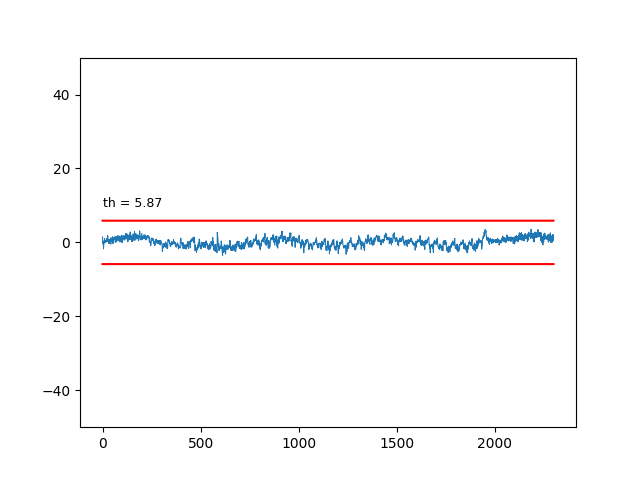

In [64]:
%matplotlib ipympl
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from scipy.stats import norm

alpha = 10**(-5) # error rate
sigma = 1 - (1 - alpha)**(1/samples)
th = norm.ppf(1 - sigma/2) # we adapt the threshold depending on number of samples
t_val = ttest_ind(traces_1, traces_2, axis=0, equal_var=False)[0]
plt.close()
plt.plot(t_val[0:], linewidth=0.75)
plt.plot([th]*scope.adc.samples, color = 'r')
plt.plot([-th]*scope.adc.samples, color='r')
y_offset = 0.5 * th  
plt.text(
    2,                  
    th + y_offset,
    f"th = {th:.2f}",
    color='black',
    fontsize=9,
    verticalalignment='bottom'
)
plt.ylim(-50, 50)
plt.show()

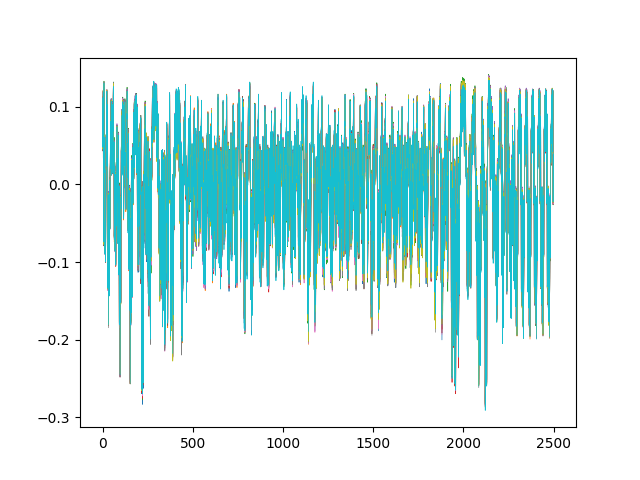

In [46]:
%matplotlib ipympl
import matplotlib.pyplot as plt

plt.close()
for t in traces_1[:10]:
    plt.plot(t[:], linewidth=0.5)
plt.show()

In [65]:
target.dis()
scope.dis()

True